[@LorenaABarba](https://twitter.com/LorenaABarba)

##### Version 0.2 -- March 2014

# Source & Sink

This is the first notebook of the *AeroPython* series, for classical Aerodynamics using Python. If you are not familiar with numerical computing using Python, be sure to first study the [*Python Crash Course*](http://nbviewer.ipython.org/github/barbagroup/AeroPython/blob/master/lessons/00_Lesson00_QuickPythonIntro.ipynb), provided as "lesson zero" of this series.

To execute this Notebook on your machine, first navigate on your console or terminal to the folder that contains the .ipynb file. Then invoke the notebook server as follows: 

`ipython notebook`

You can also read and follow along this notebook online, while typing the code into your interactive IPython prompt, or into a .py file on your favorite Python editor. Either way, make sure that you try out the codes and write your own versions!

## Overview

The theoretical basis for classical Aerodynamics is *potential-flow theory*, a mathematical apparatus that was the life-blood of aerodynamics through its growth to maturity during most of the 20th century.

It all starts with making some simplifications: 

* the flow is steady;
* the velocity remains smaller than the speed of sound (incompressible flow);
* the fluid has no internal friction, i.e., is inviscid; and
* it has no vorticity (fluid particles are not rotating). 

This sounds like a lot of simplifications, does it not? It turns out, a big chunk of aerodynamics can be approximated this way! Viscous effects are normally confined to a very thin boundary layer (and we can correct potential theory to account for that), and many flows are effectively irrotational (except for isolated points, lines or sheets). And finally, most applications that we are interested in do remain sub-sonic.

Potential-flow theory has a very pleasant mathematical quality: it is *linear*. This means that the principle of superposition applies, and we can construct new solutions by adding known solutions. 

In this notebook, you will learn two elementary potential-flow solutions: the **source**, and the **sink**. And, guess what, you will add them together to make a *new* solution called a **source-sink pair**.

### The math

---

OK, let's get down some mathematics. First, from your undergraduate fluid mechanics, you should remember the definition of *circulation*:

$$\Gamma = \oint \mathbf{v}\cdot d\vec{l}$$

In words, the circulation is the line integral of velocity around a closed contour. Squeeze your brain and extract the theorem of Stokes. It says that this line integral is equal to the *flux* through the contour of the *curl* of velocity … which is the vorticity, $\omega=\nabla\times\mathbf{v}$:

$$\oint \mathbf{v}\cdot d\vec{l} = \int \int_s \omega\cdot \vec{n}~ ds$$

If the vorticity is zero (irrotational flow), so is the circulation around any closed contour equal to zero. This means that the line integral of velocity for any curve going from A to B must be equal and opposite to that of any curve going back from B to A. Expand the dot product in the integral, where the velocity is $\mathbf{v}=(u,v,w)$ :

$$\int_A^B \mathbf{v}\cdot d\vec{l} = \int_A^B u~dx + v~dy + w~dz$$

In irrotational flow, it doesn't matter what path you take, this line integral from A to B is always the same value. Now, if you remember your vector calculus, this means that $u~dx + v~dy + w~dz~$ is an [exact differential](http://www.wolframalpha.com/input/?i=exact+differential) of a potential $\phi$, where

$$u=\frac{\partial \phi}{\partial x}, \quad v=\frac{\partial \phi}{\partial y}, \quad w=\frac{\partial \phi}{\partial z}$$

Or, for short: $\mathbf{v}=\nabla \phi$. Applying the continuity equation for incompressible flow, $\nabla\cdot\mathbf{v}=0$, we get the beautifully simple governing equation of potential flow:

$$\nabla^2\phi=0$$

*Laplace's equation!* So any solution to Laplace can be a potential flow, and here we go.


## Let's get started!

We want to numerically express the flow field of a **source** and a **sink**, two potential flow solutions, so we can plot these flows and admire them.

Start by importing some Python libraries to help you out:

* NumPy is a scientific library to create and manage multi-dimensional arrays and matrices.
* Matplotlib is a 2D plotting library that we will use to visualize our results.
* the `math` module provides the mathematical functions defined by the C standard.

Go back to our *"lesson zero,"* the [Python Crash Course](http://nbviewer.ipython.org/github/barbagroup/AeroPython/blob/master/lessons/00_Lesson00_QuickPythonIntro.ipynb), if you don't remember why and how we import our favorite libraries: 

In [1]:
import math
import numpy
import math
from numba import *              # we import numba library
from numbapro import cuda, vectorize, guvectorize, check_cuda
from numbapro import void, uint8, uint32, int32, int64, float32, float64, f8
from matplotlib import pyplot

The objective is to visualize the streamlines corresponding to a source and a sink. To do that, we need to first define a set of points where the velocity components will be computed.

Let's define an evenly spaced Cartesian grid of points within a spatial domain that is 4 units of length wide in the $x$-direction and 2 units of length wide in the $y$-direction, i.e. $x,y\in\left[-2,2\right],\left[-1,1\right]$.

The variable `N` will be the number of points  we want in each direction, and we define the computational boundaries by the variables `x_start`, `x_end`, `y_start` and `y_end`. 

We use the NumPy function [`linspace()`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html) to create two 1D arrays that contain the evenly spaced values of $x$ and $y$ coordinates, corresponding to our grid points. The last line of the code block below calls the [`meshgrid()`](http://docs.scipy.org/doc/numpy-1.4.x/reference/generated/numpy.meshgrid.html) function, which generates arrays containing the coordinates of points where the numerical solution will be calculated. Be sure to study the output of this function and understand what it does! We will use it throughout this course.

In [2]:
N = 50                                # number of points in each direction
x_start, x_end = -2.0, 2.0            # boundaries in the x-direction
y_start, y_end = -1.0, 1.0            # boundaries in the y-direction
x = numpy.linspace(x_start, x_end, N)    # creates a 1D-array with the x-coordinates
y = numpy.linspace(y_start, y_end, N)    # creates a 1D-array with the y-coordinates

print('x = ', x)
print('y = ', y)

X, Y = numpy.meshgrid(x, y)              # generates a mesh grid
print('X = ', X)
print('Y = ', Y)

x =  [-2.         -1.91836735 -1.83673469 -1.75510204 -1.67346939 -1.59183673
 -1.51020408 -1.42857143 -1.34693878 -1.26530612 -1.18367347 -1.10204082
 -1.02040816 -0.93877551 -0.85714286 -0.7755102  -0.69387755 -0.6122449
 -0.53061224 -0.44897959 -0.36734694 -0.28571429 -0.20408163 -0.12244898
 -0.04081633  0.04081633  0.12244898  0.20408163  0.28571429  0.36734694
  0.44897959  0.53061224  0.6122449   0.69387755  0.7755102   0.85714286
  0.93877551  1.02040816  1.10204082  1.18367347  1.26530612  1.34693878
  1.42857143  1.51020408  1.59183673  1.67346939  1.75510204  1.83673469
  1.91836735  2.        ]
y =  [-1.         -0.95918367 -0.91836735 -0.87755102 -0.83673469 -0.79591837
 -0.75510204 -0.71428571 -0.67346939 -0.63265306 -0.59183673 -0.55102041
 -0.51020408 -0.46938776 -0.42857143 -0.3877551  -0.34693878 -0.30612245
 -0.26530612 -0.2244898  -0.18367347 -0.14285714 -0.10204082 -0.06122449
 -0.02040816  0.02040816  0.06122449  0.10204082  0.14285714  0.18367347
  0.2244898   0.

Now that the mesh grid has been generated, it is time to visualize it with the module `pyplot` from the library `matplotlib` using the alias `plt` and the function [`scatter()`](http://matplotlib.org/api/pyplot_api.html?highlight=scatter#matplotlib.pyplot.scatter).

Note that we are getting fancy here and telling Pyplot just how we want the plot: put a label on the $x$-axis and on the $y$-axis, make the figure a certain size, make the axis limits just what *we* want, and even the [color](http://matplotlib.org/api/colors_api.html?highlight=color#module-matplotlib.colors) of the point markers. Learn about all these fancy options on the Python documentation and you will always draw pretty plots.

To get the plots inside the notebook, we use the line `%matplotlib inline` first. This simply configures the plotting module to output plots inside the IPython Notebook (instead of a pop-up window):

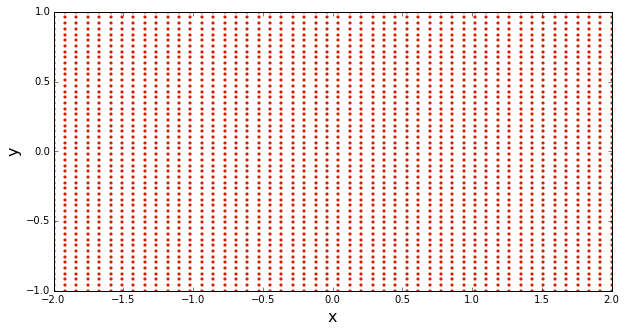

In [3]:
%matplotlib inline

# plots the grid of points
size = 10
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.scatter(X, Y, s=10, color='#CD2305', marker='o', linewidth=0)

On all of those nicely ordered points, we now will calculate the velocity vector corresponding to  a source flow. Then we'll plot the streamlines. Ready?

## Source flow

We mentioned before the nice quality of potential flow: the governing equation is *linear* and solutions can be built by superposition. For this reason, it is very useful to have a toolbox of elementary solutions that we can use as building blocks. Sources and sinks are such elementary solutions.

A *source* is a point from which we imagine that fluid is flowing out, uniformly. Thus, all the streamlines radiate from a single point as straight lines and the radial velocity decreases with the distance from the source point. Let's consider first the purely two-dimensional case. Because of the radial symmetry, it is convenient to use a cylindrical coordinate system, $\left(r,\theta\right)$. The angle $\theta$ is $\tan^{-1}(y/x)$. The velocity components (radial and tangential) are:

$$u_r\left(r,\theta\right) = \frac{\sigma}{2\pi r} \text{,} \qquad u_\theta\left(r,\theta\right)=0$$

where $\sigma$ represents the source *strength*. That the tangential velocity is zero is obvious from our requirement that the streamlines be radiating straight lines. But how do we get the radial component of velocity? Apply the irrotational-flow condition, $\omega=0$, in cylindrical coordinates, and you will get that the velocity can only be a function of $r$. Then apply the continuity equation, and you will get the result. Try it! (Go on: paper, pencil …)

You probably remember the *stream function* from undergraduate fluid mechanics. But now we are working on cylindrical coordinates. So $\psi$ is obtained from:

$$\frac{1}{r}\frac{\partial\psi}{\partial\theta} = u_r \quad \text{,} \quad -\frac{\partial\psi}{\partial r} = u_\theta$$

which integrates to

$$\psi = \frac{\sigma}{2\pi}\theta + \text{constant}$$

In practical problems, we are more interested in the velocity components that are obtained by differentiation of the stream function, so that the constant can be dropped.

In Cartesian coordinates, the velocity field $\left(u,v\right)$ at position $\left(x,y\right)$ corresponding to a source of strength $\sigma$ located at $\left(x_\text{source},y_\text{source}\right)$ is given by:

$$u = \frac{\partial\psi}{\partial y} = \frac{\sigma}{2\pi}\frac{x-x_\text{source}}{\left(x-x_\text{source}\right)^2+\left(y-y_\text{source}\right)^2}$$

and

$$v = -\frac{\partial\psi}{\partial x} = \frac{\sigma}{2\pi}\frac{y-y_\text{source}}{\left(x-x_\text{source}\right)^2+\left(y-y_\text{source}\right)^2}$$

Let's calculate the velocity field for our grid of points. We'll place the source at the location $(-1,0)$ and give it a strength $\sigma=5$. 

Instead of picking one point on the grid and calculate its velocity (which means that we would have to iterate over all positions `[i,j]`), we directly compute velocity arrays (`u_source`, `v_source`) using arithmetic operators on arrays. Yes, with Numpy, arithmetic operators on array apply elementwise and a new array is created and filled with the result.

In [27]:
strength_source = 5.0                      # source strength
x_source, y_source = -1.0, 0.0             # location of the source

# computes the velocity field on the mesh grid
def compute_velocity_cpu(u_source, v_source, X, Y, x_source, y_source, strength_source, N):
    u_source = strength_source/(2*math.pi) * (X-x_source)/((X-x_source)**2 + (Y-y_source)**2)
    v_source = strength_source/(2*math.pi) * (Y-y_source)/((X-x_source)**2 + (Y-y_source)**2)

    return u_source, v_source

CUDA version:

In [28]:
# computes the velocity field on the mesh grid
@cuda.jit('void(float32[:,:], float32[:,:], float32[:,:], float32[:,:], float32, float32, float32, int32)')
def compute_velocity_gpu_kernel(u_source, v_source, X, Y, x_source, y_source, strength_source, N):
    i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    j = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    
    if i >= N or j >= N:
        return
    
    u_source[i,j] = strength_source/(2*math.pi) * (X[i,j]-x_source)/((X[i,j]-x_source)**2 + (Y[i,j]-y_source)**2)
    v_source[i,j] = strength_source/(2*math.pi) * (Y[i,j]-y_source)/((X[i,j]-x_source)**2 + (Y[i,j]-y_source)**2)

In [29]:
def compute_velocity_gpu(u_source, v_source, X, Y, x_source, y_source, strength_source, N):
    stream = cuda.stream()
    
    # transfer from host to device
    X_d = cuda.to_device(X, stream)
    Y_d = cuda.to_device(Y, stream)
    
    # assign storage on device for output
    u_source_d = cuda.device_array_like(u_source)
    v_source_d = cuda.device_array_like(v_source)
    
    # set kernel dimensions
    blockDim = 16, 16
    gridDim  = int(numpy.ceil(float(N)/blockDim[0])), \
               int(numpy.ceil(float(N)/blockDim[1]))
    print('Thread-block dim ', blockDim)
    print('Grid dim         ', gridDim)
    
    # kernel launch
    compute_velocity_gpu_kernel[gridDim,blockDim,stream](u_source_d, v_source_d, X_d, Y_d, \
                                                         x_source, y_source, strength_source, N)

    # transfer results to host
    u_source_d.copy_to_host(u_source, stream=stream)
    v_source_d.copy_to_host(v_source, stream=stream)
    
    print('u_source = ', u_source)

    return u_source, v_source

In [30]:
u_source = numpy.empty((N,N), dtype=numpy.float32)
v_source = numpy.empty((N,N), dtype=numpy.float32)

#u_source, v_source = compute_velocity_cpu(u_source, v_source, X, Y, x_source, y_source, strength_source, N)
u_source, v_source = compute_velocity_gpu(u_source, v_source, X, Y, x_source, y_source, strength_source, N)

print('u_source = ', u_source)

Thread-block dim  (16, 16)
Grid dim          (4, 4)
u_source =  [[  7.95774698e-01  -2.22511750e-33  -4.27095072e-27 ...,  -4.27095110e-27
   -2.22511750e-33   7.95774698e-01]
 [  0.00000000e+00  -1.11255875e-33  -1.15926059e-39 ...,  -1.15926059e-39
   -1.11255875e-33   0.00000000e+00]
 [  0.00000000e+00  -2.22511750e-33  -2.13547536e-27 ...,  -2.13547536e-27
   -2.22511750e-33   0.00000000e+00]
 ..., 
 [  0.00000000e+00  -2.22511750e-33  -2.13547555e-27 ...,  -2.13547555e-27
   -2.22511750e-33   0.00000000e+00]
 [  0.00000000e+00  -1.11255875e-33  -1.15926059e-39 ...,  -1.15926059e-39
   -1.11255875e-33   0.00000000e+00]
 [  7.95774698e-01  -2.22511750e-33  -4.27095072e-27 ...,  -4.27095110e-27
   -2.22511750e-33   7.95774698e-01]]
u_source =  [[  7.95774698e-01  -2.22511750e-33  -4.27095072e-27 ...,  -4.27095110e-27
   -2.22511750e-33   7.95774698e-01]
 [  0.00000000e+00  -1.11255875e-33  -1.15926059e-39 ...,  -1.15926059e-39
   -1.11255875e-33   0.00000000e+00]
 [  0.00000000e+00  

Let's plot the stream lines already! We are lucky that the contributors to the open Python world have added a [`streamplot()`](http://matplotlib.org/users/whats_new.html#streamplot) function that does it all. We'll also use the [`scatter()`](http://matplotlib.org/api/pyplot_api.html?highlight=scatter#matplotlib.pyplot.scatter) function to put a red dot right on the source.

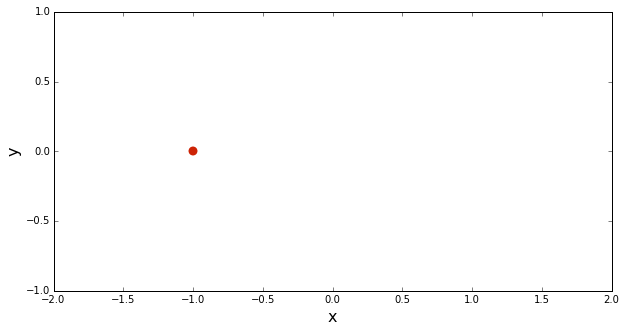

In [22]:
# plotting the streamlines
size = 10
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.streamplot(X, Y, u_source, v_source, density=2, linewidth=1, arrowsize=2, arrowstyle='->')
pyplot.scatter(x_source, y_source, color='#CD2305', s=80, marker='o', linewidth=0);

Cool. Just like we thought a source should look, only prettier. Note that we added a semicolon on the lastest instruction of the cell above, to suppress the display of the object's instance.

We recommend that after following this notebook carefully, you prepare your own Python code separately, following our example. *Type* the code (instead of copying and pasting), so you assimilate what you are doing. Try things out, change parameters, read the Python documentation when needed. Remember, we will build more complicated flow solutions later on, so be sure to get a good foundation.

##### Challenge question

What is the total mass flux outwards of a small closed surface around the source?

## Sink flow

In the source flow, the strength $\sigma$ was chosen to be positive. A source with a *negative* strength is called a *sink*. Instead of radiating from a single point, the straight streamlines are now converging to a single point.

The velocity field corresponding to a sink looks similar to that of a source, except for the direction of the flow. Thus, the Python code requires very few modifications.

We will place the sink at the location $(1,0)$ and give it an equal strength to our source, but negative of course.

In [ ]:
strength_sink = -5.0                     # strength of the sink
x_sink, y_sink = 1.0, 0.0                # location of the sink

# computes the velocity on the mesh grid
u_sink = strength_sink/(2*math.pi) * (X-x_sink)/((X-x_sink)**2 + (Y-y_sink)**2)
v_sink = strength_sink/(2*math.pi) * (Y-y_sink)/((X-x_sink)**2 + (Y-y_sink)**2)

In [ ]:
# plots the streamlines
size = 10
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.streamplot(X, Y, u_sink, v_sink, density=2, linewidth=1, arrowsize=2, arrowstyle='->')
pyplot.scatter(x_sink, y_sink, color='#CD2305', s=80, marker='o', linewidth=0);

## Source-sink pair

Now, let's exercise our superposition powers. We already have the velocity field of the source and the velocity field of the sink. We can just add these velocity fields, point wise, to get a new solution of potential flow: the **source-sink pair**. Read this code carefully and make sure you understand what it's doing!

In [ ]:
# computes the velocity of the pair source/sink by superposition
u_pair = u_source + u_sink
v_pair = v_source + v_sink

# plots the streamlines of the pair source/sink
size = 10
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end)
pyplot.streamplot(X, Y, u_pair, v_pair, density=2.0, linewidth=1, arrowsize=2, arrowstyle='->')
pyplot.scatter([x_source, x_sink], [y_source, y_sink], 
            color='#CD2305', s=80, marker='o', linewidth=0);

Change things around! Move the location of the source and sink, make them stronger. What happens?


##### Challenge task

Write your own code for plotting the *potential lines*, instead of the stream lines. You might want to use the [`contour()`](http://matplotlib.org/examples/pylab_examples/contour_demo.html) function for this.

---

In [ ]:
from IPython.core.display import HTML
def css_styling():
    styles = open('../styles/custom.css', 'r').read()
    return HTML(styles)
css_styling()